<a href="https://colab.research.google.com/github/nazirumar/NLP/blob/main/clustering_documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recipe 5-5. Clustering Documents**

Document clustering, also called text clustering, is a cluster analysis
on textual documents. One of the typical usages would be document
management.

**Problem**

Clustering or grouping the documents based on the patterns and
similarities.

**Solution**

Document clustering yet again includes similar steps, so let’s have a look at
them:
1. Tokenization
2. Stemming and lemmatization
3. Removing stop words and punctuation
4. Computing term frequencies or TF-IDF
5. Clustering: K-means/Hierarchical; we can then use
any of the clustering algorithms to cluster different
documents based on the features we have generated
6. Evaluation and visualization: Finally, the clustering
results can be visualized by plotting the clusters into
a two-dimensional space

**Step 5-1 Import data and libraries**

here are the libraries, then the data

In [1]:
!pip install mpld3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 6.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

#Lets use the same complaint dataset we use for classification


In [5]:
df = pd.read_csv("/content/drive/MyDrive/NLP/consumer_complaints.csv", encoding='latin-1')
df.head()

<ipython-input-5-e9d26fb191c8>:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/NLP/consumer_complaints.csv", encoding='latin-1')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [6]:
#selecting required columns and rows
df = df[['consumer_complaint_narrative']]
df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [11]:
# lets do the clustering for just 200 documents. Its easier to interpret.
Data_sample=df.sample(200)
Data_sample

,consumer_complaint_narrative
233188,I have had a mortgage on my current house and ...
304963,Case number : XXXXAs previously stated every t...
263465,I have received debt collection notices from a...
304997,"On XXXX XXXX, 2015 I initiated a bank transfer..."
319398,My mortgage servicing was sold to Green Tree/D...
...,...
260460,Dear Sir/Madam : Please note : I am filing a n...
305986,Due to a divorce I had to declare bankruptcy a...
296947,"on XXXX/XXXX/2015, I filed an dispute with XXX..."
254000,I attended XXXX XXXX in XXXX MA. Now I have Fe...


**Step 5-2 Preprocessing and TF-IDF feature engineering**

In [13]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
#Remove unwanted symbol

Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX', "")
#Convert dataframe to list
complaints = Data_sample['consumer_complaint_narrative'].tolist()
# create the rank of documents -- we will use it later

ranks = []
for i in range(1, len(complaints) +1):
  ranks.append(i)

# Stop Words

stopwords = nltk.corpus.stopwords.words('english')

# Load 'stemmer

stemmer = SnowballStemmer('english')


In [19]:
# Function for sentence tokenizer, to remove numeric tokens and raw
# punctuation

def tokenize_and_stem(text):
  tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  for token in tokens:
    if re.search('[a-zA-Z]', token):
      filtered_tokens.append(token)
  stems = [stemmer.stem(t) for t in filtered_tokens]
  return stems

def tokenize_only(text):
  tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  for token in tokens:
    if re.search('[a-zA-Z]', token):
      filtered_tokens.append(token)

  return filtered_tokens

**tfidf vectorizer**

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
 min_df=0.2, stop_words='english',
 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))


In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
#fit the vectorizer to data

tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names_out()
print(tfidf_matrix.shape)

(200, 29)


**Step 5-3 Clustering using K-means**

In [28]:
#import K-means

from sklearn.cluster import KMeans

#Define number of clusters
num_clusters = 6

#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6)

In [29]:
#final clusters
clusters = km.labels_.tolist()
complaints_data = {'rank':ranks, 'complaint':complaints, 'cluster': clusters}

frame = pd.DataFrame(complaints_data, index= [clusters], columns=['rank', 'cluster'])
frame

,rank,cluster
1,1,1
4,2,4
0,3,0
2,4,2
5,5,5
...,...,...
1,196,1
3,197,3
0,198,0
4,199,4


In [30]:
#number of docs per cluster
frame['cluster'].value_counts()

2    40
1    38
3    36
4    33
0    27
5    26
Name: cluster, dtype: int64

**Step 5-4 Identify cluster behavior**

*Step 5-4 Identify cluster behavior*

In [32]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
  allwords_stemmed = tokenize_and_stem(i)
  totalvocab_stemmed.extend(allwords_stemmed)

  allwords_tokenized = tokenize_only(i)
  totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index=totalvocab_stemmed)

In [33]:
vocab_frame

,words
i,i
have,have
had,had
a,a
mortgag,mortgage
...,...
was,was
origin,originated
over,over
year,years


In [35]:
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
  print("Cluster %d words:" % i, end="")
  for ind in order_centroids[i, :6]:
    print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
  print()

Cluster 0 words: b'debt', b'company', b'credit', b'stated', b'any', b'because',
Cluster 1 words: b'report', b'credit', b'credit', b'informing', b'account', b'receiving',
Cluster 2 words: b'account', b'bank', b'times', b"n't", b'credit', b'did',
Cluster 3 words: b'receiving', b'years', b'told', b'company', b'did', b'ask',
Cluster 4 words: b'loan', b'pay', b'stated', b'company', b'did', b'payments',
Cluster 5 words: b'payments', b'months', b'stated', b'pay', b'times', b"n't",


**Step 5-5 Plot the clusters on a 2D graph**

*Finally, we plot the clusters:

Similarity*

In [38]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

#Convert two component as we're plotting points in a two-diemsional plane

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(similarity_distance)
# shape (n_components, n_samples)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [46]:
xs, ys = pos[:, 0], pos[:, 1]
#Set up colors per clusters using a dict
cluster_colors =  {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3',3: '#e7298a', 4: '#66a61e', 5: '#D2691E'}
#set up cluster names using a dict
cluster_names = {0: 'property, based, assist',
                  1: 'business, card',
                  2: 'authorized, approved, believe',
                  3: 'agreement, application,business',
                  4: 'closed, applied, additional',
                  5: 'applied, card'}

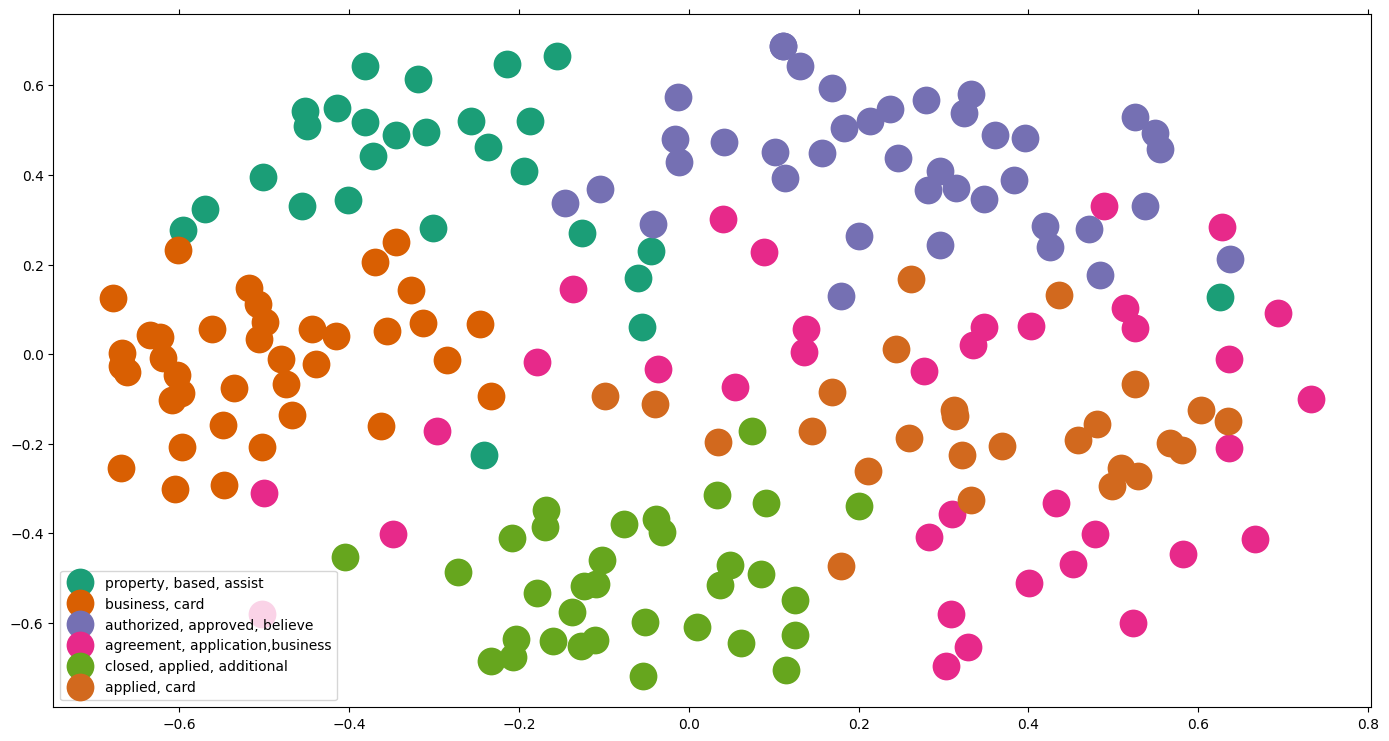

In [69]:
# Finally plot it
%matplotlib inline

#Create data frame that has the result of the MDS and the cluster

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')
#Set up plot

fig, ax = plt.subplots(figsize=(17,9)) #set size
for name, group in groups:
  ax.plot(group.x, group.y, marker='o', linestyle='', ms=20,
          label=cluster_names[name], color=cluster_colors[name], mec='none')
  ax.set_aspect('auto')
  ax.tick_params(\
                 axis='x',
                 which='both',
                 bottom='off',
                 top='off',
                 labelbottom = 'off')
  ax.tick_params(\
      axis='y',
      which='both',
      left='off',
      top='off',
      labelleft='off')
ax.legend(numpoints=1)
plt.show()